# Analyse de Clustering avec GMM sur OpenFoodFacts
### Table des matières
1. [Chargement et préparation des données](#1),
2. [Prétraitement et nettoyage](#2),
3. [Sélection des features pour le clustering](#3),
4. [Préparation pour GMM](#4),
5. [Modélisation GMM](#5),
6. [Analyse des clusters](#6),
7. [Visualisation des résultats](#7)

## Chargement et préparation des données


In [3]:
import sys
sys.path.append('..')
from scripts.Exploration_utils import load_data, check_missing_values
from scripts.Cleaning_utils import (
    preprocess_dataframe, 
    get_feature_names, 
    analyze_data_quality, 
    check_data_consistency, 
    standardize_values,
    handle_duplicates,
    select_relevant_features,
    plot_distributions,
    analyze_correlations,
    analyze_feature_importance
)
from scripts.Clustering_utils import (
    prepare_features_for_clustering, 
    analyze_and_select_features
)
import pandas as pd

In [4]:
#on va d'abord charger les données pour voir la taille du dataset et les colonnes disponibles
df = load_data("../data/en.openfoodfacts.org.products.csv")
print(df.shape)
print(df.columns.values)

(3655184, 206)
['code' 'url' 'creator' 'created_t' 'created_datetime' 'last_modified_t'
 'last_modified_datetime' 'last_modified_by' 'last_updated_t'
 'last_updated_datetime' 'product_name' 'abbreviated_product_name'
 'generic_name' 'quantity' 'packaging' 'packaging_tags' 'packaging_en'
 'packaging_text' 'brands' 'brands_tags' 'categories' 'categories_tags'
 'categories_en' 'origins' 'origins_tags' 'origins_en'
 'manufacturing_places' 'manufacturing_places_tags' 'labels' 'labels_tags'
 'labels_en' 'emb_codes' 'emb_codes_tags' 'first_packaging_code_geo'
 'cities' 'cities_tags' 'purchase_places' 'stores' 'countries'
 'countries_tags' 'countries_en' 'ingredients_text' 'ingredients_tags'
 'ingredients_analysis_tags' 'allergens' 'allergens_en' 'traces'
 'traces_tags' 'traces_en' 'serving_size' 'serving_quantity'
 'no_nutrition_data' 'additives_n' 'additives' 'additives_tags'
 'additives_en' 'nutriscore_score' 'nutriscore_grade' 'nova_group'
 'pnns_groups_1' 'pnns_groups_2' 'food_groups' 'fo

In [5]:
check_missing_values(df)

⚠️ 200 colonnes sur 206 ont des valeurs manquantes.
allergens_en                 99.999973
cities                       99.999945
glycemic-index_100g          99.999808
elaidic-acid_100g            99.999781
chlorophyl_100g              99.999754
                               ...    
main_category                57.098056
categories_en                57.098028
categories_tags              57.098001
categories                   57.097810
environmental_score_grade    51.395853
Length: 168, dtype: float64


allergens_en           99.999973
cities                 99.999945
glycemic-index_100g    99.999808
elaidic-acid_100g      99.999781
chlorophyl_100g        99.999754
                         ...    
last_updated_t          0.009658
creator                 0.000356
states_tags             0.000055
states_en               0.000055
states                  0.000055
Length: 200, dtype: float64

In [6]:
# First get the preprocessed dataframe and feature info
preprocessed_df, feature_info = preprocess_dataframe(df)

# Then pass the feature_info dictionary to get_feature_names
feature_names = get_feature_names(feature_info)

Colonnes numériques conservées: 9
Colonnes catégorielles ordinales: 0
Colonnes catégorielles nominales: 11
Colonnes supprimées: 186
Colonnes optimisées (downcasting): 2


In [7]:
#on va maintenant afficher les colonnes conservées
print(feature_names)
#on va maintenant afficher les informations sur les colonnes
print(feature_info)
#on va maintenant afficher les colonnes conservées
print(feature_names)

['created_t', 'last_modified_t', 'last_updated_t', 'last_image_t', 'energy-kcal_100g', 'carbohydrates_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'cities', 'ingredients_analysis_tags', 'no_nutrition_data', 'additives_n', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_tags', 'food_groups_en', 'environmental_score_grade']
{'numerical_columns': ['created_t', 'last_modified_t', 'last_updated_t', 'last_image_t', 'energy-kcal_100g', 'carbohydrates_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g'], 'categorical_ordinal': [], 'categorical_nominal': ['cities', 'ingredients_analysis_tags', 'no_nutrition_data', 'additives_n', 'nutriscore_grade', 'pnns_groups_1', 'pnns_groups_2', 'food_groups', 'food_groups_tags', 'food_groups_en', 'environmental_score_grade'], 'dropped_columns': [('allergens_en', 'low_unique_ratio'), ('nova_group', 'low_unique_ratio'), ('environmental_score

In [8]:
df_clean, duplication_info = handle_duplicates(df, strategy='analyze')
print(f"Nombre de doublons trouvés : {duplication_info['duplicate_count']}")
print(f"Nombre total de doublons: {duplication_info['duplicate_count']}")

Nombre de doublons trouvés : 0
Nombre total de doublons: 0


In [9]:
print("\nMotifs de duplication par colonne:")
for col, count in duplication_info['duplicate_patterns']['partial_duplicates'].items():
    if count > 0:
        print(f"{col}: {count} doublons")


Motifs de duplication par colonne:
code: 3439 doublons
url: 3108 doublons
creator: 3621343 doublons
created_t: 294024 doublons
created_datetime: 294024 doublons
last_modified_t: 661716 doublons
last_modified_datetime: 661716 doublons
last_modified_by: 3613946 doublons
last_updated_t: 2856373 doublons
last_updated_datetime: 2856373 doublons
product_name: 1512381 doublons
abbreviated_product_name: 3630741 doublons
generic_name: 3533540 doublons
quantity: 3594123 doublons
packaging: 3592280 doublons
packaging_tags: 3605429 doublons
packaging_en: 3605795 doublons
packaging_text: 3640126 doublons
brands: 3295813 doublons
brands_tags: 3378358 doublons
categories: 3401173 doublons
categories_tags: 3499565 doublons
categories_en: 3499581 doublons
origins: 3633781 doublons
origins_tags: 3638203 doublons
origins_en: 3638389 doublons
manufacturing_places: 3618459 doublons
manufacturing_places_tags: 3622643 doublons
labels: 3495917 doublons
labels_tags: 3539996 doublons
labels_en: 3540001 doublon

In [10]:
if duplication_info['duplicate_count'] > 0:
    # Choisir la stratégie appropriée
    df_clean, cleaning_info = handle_duplicates(df, strategy='keep_last')
    print(f"\nNombre de lignes supprimées: {cleaning_info['removed_rows']}")

1. Prétraitement initial du DataFrame
Colonnes numériques conservées: 4
Colonnes catégorielles ordinales: 0
Colonnes catégorielles nominales: 5
Colonnes supprimées: 197
Colonnes optimisées (downcasting): 2

2. Résumé des colonnes conservées:
- Numériques: 4
- Catégorielles ordinales: 0
- Catégorielles nominales: 5

3. Colonnes numériques optimisées (downcasting):
- created_t: int64 -> uint32
- last_modified_t: int64 -> uint32

4. Colonnes catégorielles filtrées (> {max_categories} catégories supprimées):
- code
- url
- creator
- created_datetime
- last_modified_datetime
- last_modified_by
- last_updated_datetime
- product_name
- abbreviated_product_name
- generic_name
- quantity
- packaging
- packaging_tags
- packaging_en
- packaging_text
- brands
- brands_tags
- categories
- categories_tags
- categories_en
- origins
- origins_tags
- origins_en
- manufacturing_places
- manufacturing_places_tags
- labels
- labels_tags
- labels_en
- emb_codes
- emb_codes_tags
- first_packaging_code_geo
-

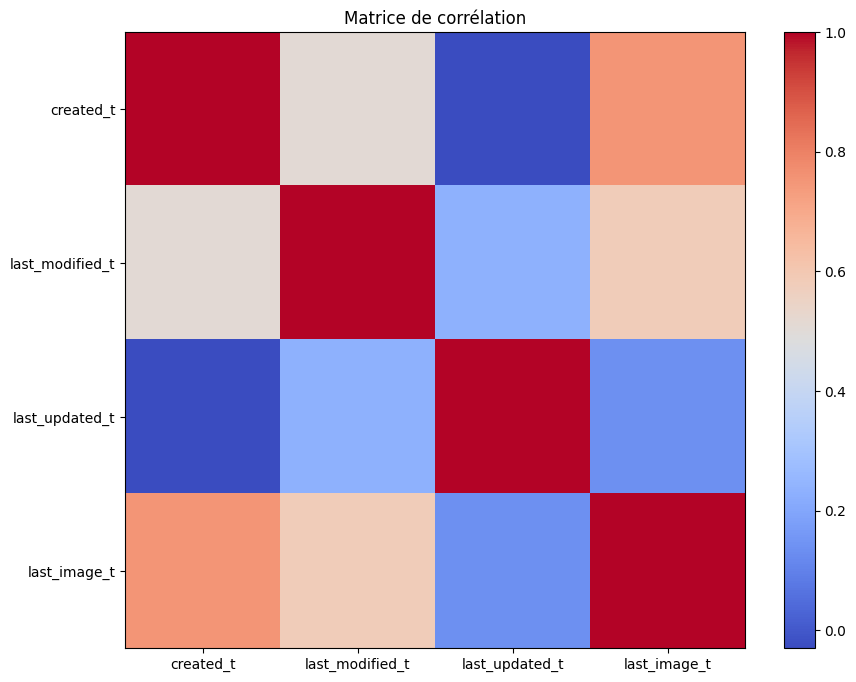


Variables fortement corrélées à examiner:
- created_t - last_image_t: 0.75

Features sélectionnées pour la clusterisation:
- created_t (numérique)
- last_modified_t (numérique)
- last_updated_t (numérique)
- last_image_t (numérique)
- cities (catégorielle nominale)
- no_nutrition_data (catégorielle nominale)
- nutriscore_grade (catégorielle nominale)
- pnns_groups_1 (catégorielle nominale)
- environmental_score_grade (catégorielle nominale)


In [11]:
# Préparation des données pour la clusterisation
df_prepared, feature_info = prepare_features_for_clustering(
    df,
    max_categories=30,  # Ajustez selon vos besoins
    min_unique_ratio=0.05
)

# Affichage des features finales
print("\nFeatures sélectionnées pour la clusterisation:")
final_features = get_feature_names(feature_info)
for feature in final_features:
    if feature in feature_info['numerical_columns']:
        print(f"- {feature} (numérique)")
    elif feature in feature_info['categorical_ordinal']:
        print(f"- {feature} (catégorielle ordinale)")
    else:
        print(f"- {feature} (catégorielle nominale)")

In [12]:
# Application de la fonction
feature_info = analyze_and_select_features(df)

# Affichage des résultats
print("Variables numériques sélectionnées:")
for col in feature_info['numerical_columns']:
    print(f"- {col}")

print("\nVariables catégorielles ordinales:")
for col in feature_info['categorical_ordinal']:
    print(f"- {col}")

print("\nVariables catégorielles nominales:")
for col in feature_info['categorical_nominal']:
    print(f"- {col}")

print("\nColonnes optimisées (downcasting):")
for col, info in feature_info['downcasted_columns'].items():
    print(f"- {col}: {info['original_dtype']} -> {info['new_dtype']}")

print("\nColonnes exclues:")
for col, reason in feature_info['dropped_columns']:
    print(f"- {col} (raison: {reason})")

Variables numériques sélectionnées:
- created_t
- last_modified_t
- last_updated_t
- last_image_t
- energy-kcal_100g
- carbohydrates_100g
- salt_100g
- sodium_100g

Variables catégorielles ordinales:
- nutriscore_grade

Variables catégorielles nominales:
- pnns_groups_1

Colonnes optimisées (downcasting):
- created_t: int64 -> int32
- last_modified_t: int64 -> int32

Colonnes exclues:
- code (raison: too_many_categories)
- url (raison: too_many_categories)
- creator (raison: too_many_categories)
- created_datetime (raison: too_many_categories)
- last_modified_datetime (raison: too_many_categories)
- last_modified_by (raison: too_many_categories)
- last_updated_datetime (raison: too_many_categories)
- product_name (raison: too_many_categories)
- abbreviated_product_name (raison: too_many_missing)
- generic_name (raison: too_many_missing)
- quantity (raison: too_many_missing)
- packaging (raison: too_many_missing)
- packaging_tags (raison: too_many_missing)
- packaging_en (raison: too_ma